In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# For Jupyter Notebook inline plotting
%matplotlib inline

# Use a built-in style (e.g., 'ggplot')
plt.style.use('ggplot')


In [21]:
# Define the file path for the movie information
file_film = 'ml-100k/u.item'

# Define column names for the u.item file
film_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown',
    'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi',
    'Thriller', 'War', 'Western'
]

# Load the dataset (ensure the encoding is correct)
film_info = pd.read_csv(file_film, sep='|', names=film_cols, encoding='ISO-8859-1')

# Display the first few rows of the dataset
print("First few rows of the film dataset:")
print(film_info.head())


First few rows of the film dataset:
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Childrens  ...  Fantasy  Film Noir  Horror  Musical  \
0          0          1          1  ...   

In [22]:
# Define the list of genre columns (excluding 'unknown')
genre_cols = [
    'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western'
]

# Extract the genre features as a NumPy array
movie_features = film_info[genre_cols].values

# Compute the cosine similarity matrix between movies based on genre features
cosine_sim = cosine_similarity(movie_features)

print("Cosine similarity matrix shape:", cosine_sim.shape)


Cosine similarity matrix shape: (1682, 1682)


In [23]:
def get_recommendations(title, cosine_sim=cosine_sim, df=film_info, top_n=10):
    """
    Given a movie title, return the top_n most similar movies based on genre features.
    """
    # Reset index to refer to positions correctly
    df = df.reset_index(drop=True)
    
    # Create a Series mapping movie titles to their indices (drop duplicates)
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    
    if title not in indices:
        print("Movie not found in the dataset.")
        return pd.DataFrame()
    
    idx = indices[title]
    
    # Get the pairwise similarity scores for the movie with index idx
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores (in descending order)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the first movie (itself) and select the top_n movies
    sim_scores = sim_scores[1: top_n + 1]
    
    # Get the movie indices of the most similar movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Create a DataFrame with recommendations and similarity scores
    recommendations = df.iloc[movie_indices][['movie_id', 'title']].copy()
    recommendations['similarity'] = [i[1] for i in sim_scores]
    
    # Return recommendations sorted by similarity (highest first)
    return recommendations.sort_values('similarity', ascending=False)


In [24]:
# Test the recommendation function using a sample movie title
movie_title = 'Toy Story (1995)'
recommendations = get_recommendations(movie_title, top_n=10)

print(f"Recommendations for '{movie_title}':\n")
print(recommendations.to_string(index=False))


Recommendations for 'Toy Story (1995)':

 movie_id                                  title  similarity
      422 Aladdin and the King of Thieves (1996)    1.000000
       95                         Aladdin (1992)    0.866025
     1219                  Goofy Movie, A (1995)    0.866025
       63               Santa Clause, The (1994)    0.816497
       94                      Home Alone (1990)    0.816497
      102                 Aristocats, The (1970)    0.816497
      138            D3: The Mighty Ducks (1996)    0.816497
      139                   Love Bug, The (1969)    0.816497
      169             Wrong Trousers, The (1993)    0.816497
      189                Grand Day Out, A (1992)    0.816497


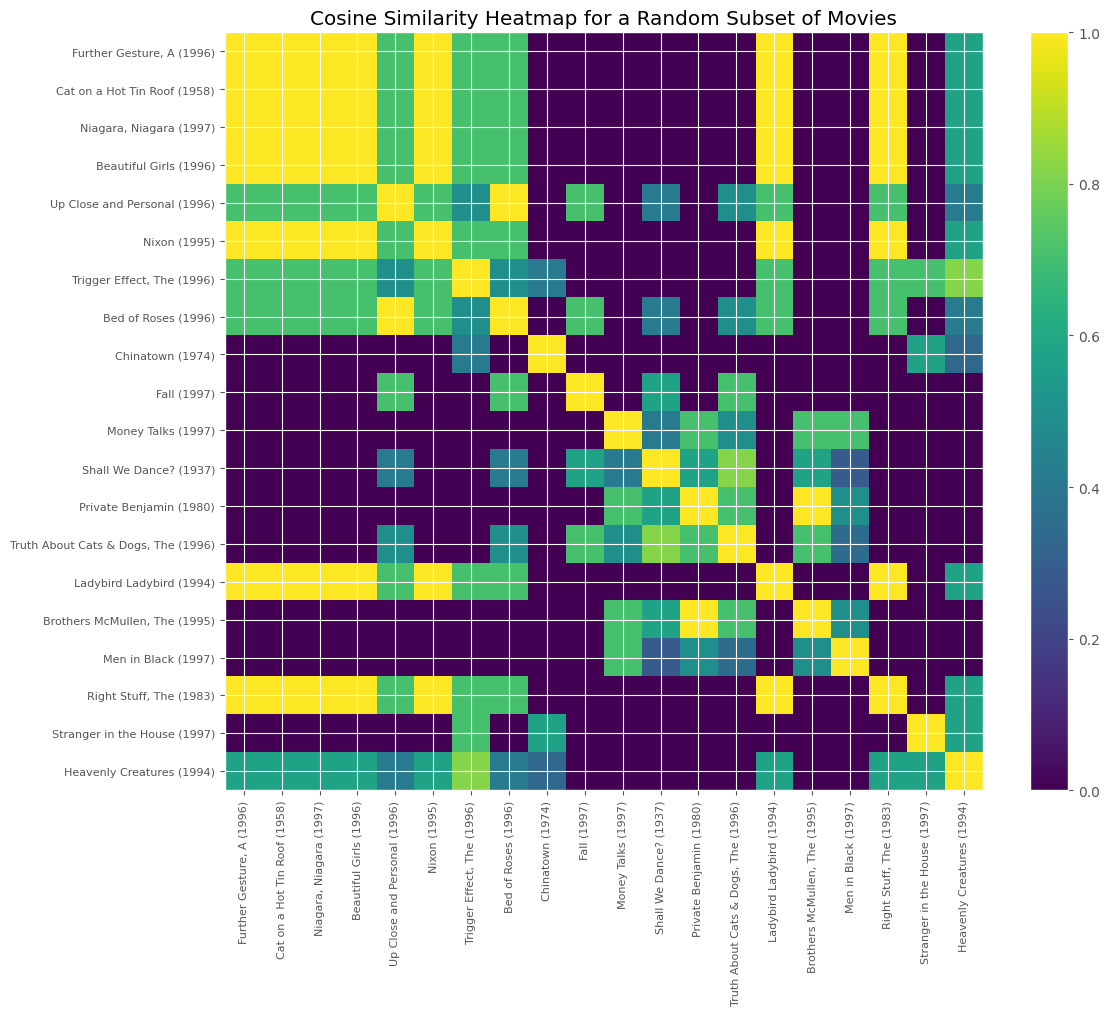

In [25]:
# Select a random subset of 20 movies from the dataset
subset_indices = np.random.choice(film_info.index, size=20, replace=False)
subset_titles = film_info.loc[subset_indices, 'title'].values
subset_sim = cosine_sim[subset_indices][:, subset_indices]

plt.figure(figsize=(12, 10))
plt.imshow(subset_sim, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(ticks=np.arange(len(subset_titles)), labels=subset_titles, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(subset_titles)), labels=subset_titles, fontsize=8)
plt.title('Cosine Similarity Heatmap for a Random Subset of Movies')
plt.tight_layout()
plt.show()


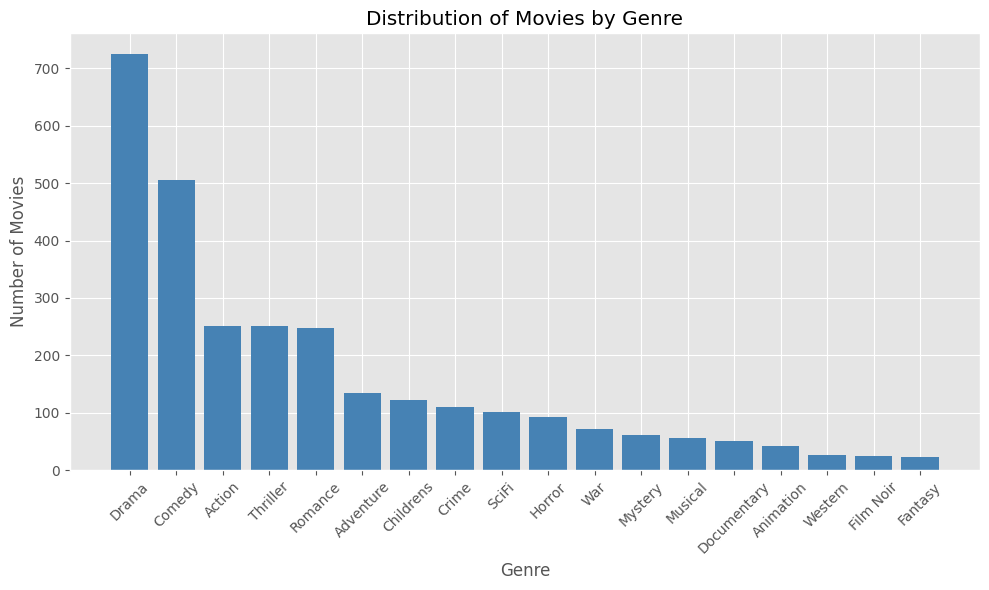

In [26]:
# Sum the genre columns to get the count of movies per genre
genre_counts = film_info[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='steelblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# -------------------------------
# Load the user ratings data
# -------------------------------
# Define column names for the ratings file (ml-100k/u.data)
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# Load the ratings data (assuming the file is tab-separated)
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='ISO-8859-1')

# Create a mapping from movie_id (from u.item) to the DataFrame index in film_info
movie_id_to_index = pd.Series(film_info.index, index=film_info['movie_id']).to_dict()

# Filter out any ratings for movies that are not in the film_info dataset
ratings = ratings[ratings['movie_id'].isin(movie_id_to_index.keys())]

# -------------------------------
# Split data into training and test sets
# -------------------------------
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# -------------------------------
# Define a function to predict ratings using content-based filtering
# -------------------------------
def predict_rating(user_id, movie_id, train_ratings, cosine_sim, movie_id_to_index):
    """
    Predicts the rating for a given user and movie by computing a weighted average
    of the ratings the user gave in the training set. Weights are the cosine similarity
    scores between the target movie and each movie the user has rated.
    """
    # If the movie is not in the mapping, return None (or choose a fallback)
    if movie_id not in movie_id_to_index:
        return None
    target_idx = movie_id_to_index[movie_id]
    
    # Retrieve all movies the user has rated in the training set
    user_train_ratings = train_ratings[train_ratings['user_id'] == user_id]
    
    # If the user has no training ratings, fallback to the global training average
    if user_train_ratings.empty:
        return train_ratings['rating'].mean()
    
    numerator = 0.0
    denominator = 0.0
    
    # Loop over each movie the user has rated
    for _, row in user_train_ratings.iterrows():
        rated_movie_id = row['movie_id']
        rating = row['rating']
        # Ensure the rated movie exists in our film_info mapping
        if rated_movie_id not in movie_id_to_index:
            continue
        rated_idx = movie_id_to_index[rated_movie_id]
        # Get the cosine similarity between the target movie and the rated movie
        sim = cosine_sim[target_idx, rated_idx]
        numerator += sim * rating
        denominator += sim
    
    # If the sum of similarities is positive, compute weighted average;
    # otherwise, fallback to the user's average rating from training data.
    if denominator > 0:
        return numerator / denominator
    else:
        return user_train_ratings['rating'].mean()

# -------------------------------
# Predict ratings for the test set and compute the MSE
# -------------------------------
predictions = []

# Loop over each test rating and predict its value using our CBF approach
for _, row in test_ratings.iterrows():
    pred = predict_rating(row['user_id'], row['movie_id'], train_ratings, cosine_sim, movie_id_to_index)
    predictions.append(pred)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(test_ratings['rating'], predictions)
print("Mean Squared Error (MSE) for Content-Based Filtering:", mse)


Mean Squared Error (MSE) for Content-Based Filtering: 1.0582170552010215
